### PySpark : Tweet Sentiment Analysis (Sentiment140 dataset with 1.6 million tweets)

Text classification using PySpark ML
This Notebook utilizes Machine Learning with PySpark to categorize tweets.Dataset [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140)

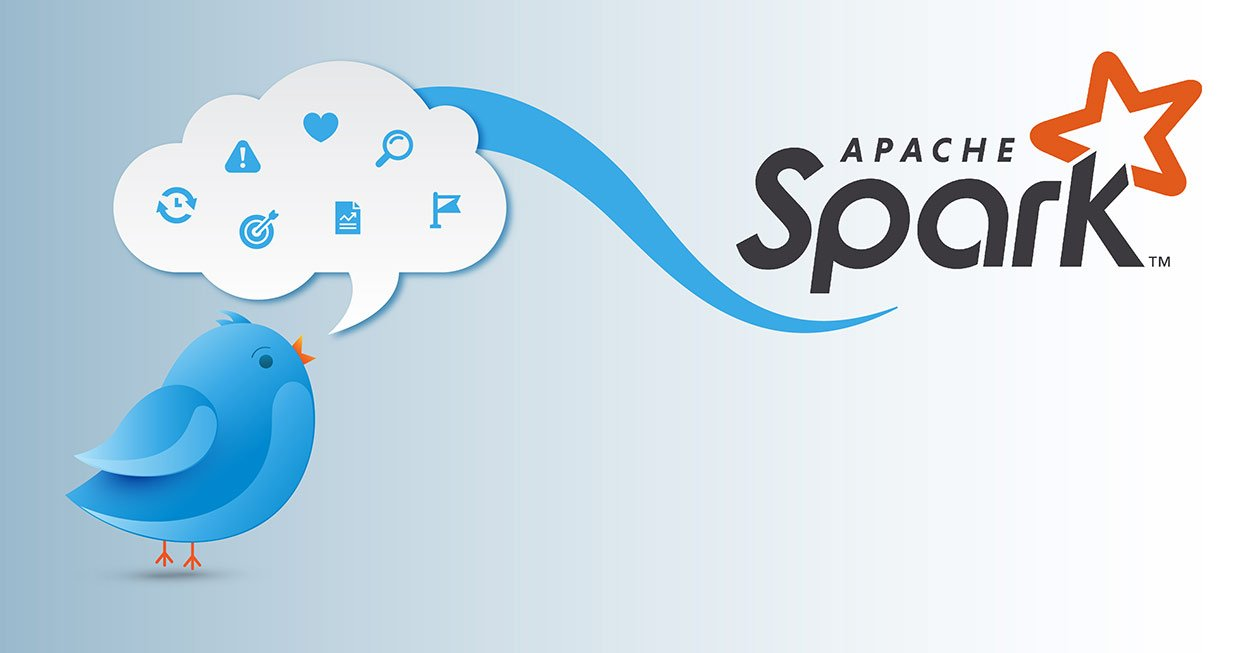

In [71]:
from IPython.display import Image
Image("/content/Sentiment-analysis-using-Spark.jpg")

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 70kB/s 
     |████████████████████████████████| 204kB 19.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=5cfc2841eec5272aaad11e5ab74974136c1776e4e61e97c9a06475c9f916655a
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 83% 67.0M/80.9M [00:01<00:00, 43.0MB/s]
100% 80.9M/80.9M [00:01<00:00, 72.4MB/s]


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


## Importing necessary libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover,HashingTF, IDF

In [ ]:
!pip install spacy

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy # NLP
import re # regular expressions
import html # HTML content, like &amp;
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem import PorterStemmer


## Create a Spark session

In [ ]:
spark = SparkSession.builder.appName('tweet').getOrCreate()

In [ ]:
df = spark.read.csv('/content/training.1600000.processed.noemoticon.csv', inferSchema = True,)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



It contains the following 6 fields:

- __target__: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

- __ids__: The id of the tweet ( 2087)

- __date__: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

- __flag__: The query (lyx). If there is no query, then this value is NO_QUERY.

- __user__: the user that tweeted (robotickilldozr)

- __text__: the text of the tweet (Lyx is cool)

In [ ]:
df = df.withColumnRenamed("_c0", "target").withColumnRenamed("_c1", "id").withColumnRenamed("_c2", "data").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

In [ ]:
df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                data|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

__Predictor variables__: text

__Outcome variable__: target

In [ ]:
df.groupBy('target').count().show()

+------+------+
|target| count|
+------+------+
|     4|800000|
|     0|800000|
+------+------+



##### Refference:
https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

In [ ]:
#For each column, count cases where the column is NaN or Null
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show() #Check for null values

+------+---+----+----+----+----+
|target| id|data|flag|user|text|
+------+---+----+----+----+----+
|     0|  0|   0|   0|   0|   0|
+------+---+----+----+----+----+



In [ ]:
#Change tweet sentiment to 0 and 1 instead of 0 and 4
df = df.withColumn("target",when(df["target"] == 4, 1).otherwise(df["target"]))

In [ ]:
# Clean text
df_clean = df.select('target', (lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')))

# Tokenize text
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('target', 'words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('target', 'words_clean')

# Stem text
stemmer =PorterStemmer()
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('target', 'words_stemmed')

# Filter length word > 5
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))

In [ ]:
# tf-idf
hashingTF = HashingTF(inputCol="words_stemmed", outputCol="rawFeatures") #generate vectors
featurizedData = hashingTF.transform(df_final_words)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

## Split the dataset into train and test sets

In [ ]:
train, test = rescaledData.randomSplit([0.7, 0.3])

## Naive Bayes Classifier

In [ ]:
nb = NaiveBayes(modelType="multinomial",labelCol="target", featuresCol="features")
nbModel = nb.fit(train)
nb_predictions = nbModel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Accuracy of NaiveBayes is = %g"% (nb_accuracy))

Accuracy of NaiveBayes is = 0.710914


## Logistic Regression Model

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'target', maxIter=10)
lrModel = lr.fit(train)
lrPreds = lrModel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lrPreds)
print("Accuracy of Logistic Regression is = %g"% (lr_accuracy))

Accuracy of Logistic Regression is = 0.730267


## Decision Tree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target', maxDepth = 3)
dtModel = dt.fit(train)
dtPreds = dtModel.transform(test)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f80cbc554d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dtPreds)
print("Accuracy of Decision Trees is = %g"% (dt_accuracy))

## Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rfPreds)
print("Accuracy of Random Forests is = %g"% (rf_accuracy))